In [4]:
from __future__ import print_function
import sys
sys.setrecursionlimit(99999)
import pdb

import numpy as np
np.random.seed(1337)  # for reproducibility

import keras

from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import ZeroPadding2D, AveragePooling2D, Convolution2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization

import residual_blocks
from keras import backend as K
K.set_image_dim_ordering('th')

batch_size = 40
nb_classes = 1
nb_epoch = 100

In [8]:
def compute_padding_length(length_before, stride, length_conv):
    ''' Assumption: you want the subsampled result has a length of floor(original_length/stride).
    '''
    N = length_before
    F = length_conv
    S = stride
    if S == F:
        return 0
    if S == 1:
        return (F-1)/2
    for P in range(S):
        if (N-F+2*P)/S + 1 == N/S:
            return P
    return None

def design_for_residual_blocks(num_channel_input=1):
    ''''''
    model = Sequential() # it's a CONTAINER, not MODEL
    # set numbers
    num_big_blocks = 5
    image_patch_sizes = [[3,3]]*num_big_blocks
    pool_sizes = [(2,2)]*num_big_blocks
    n_features =      [24, 48, 64, 96, 128]
    n_features_next = [48, 64, 96, 128, 192]
    height_input = 128
    width_input  = 128
    
    for conv_idx in range(num_big_blocks):    
        n_feat_here = n_features[conv_idx]
        # residual block 0
        model.add(residual_blocks.building_residual_block(  (num_channel_input, height_input, width_input),
                                                            n_feat_here,
                                                            kernel_sizes=image_patch_sizes[conv_idx]
                                                            ))

        # residual block 1 (you can add it as you want (and your resources allow..))
        if False:
            print('add another block')
            model.add(residual_blocks.building_residual_block(  (n_feat_here, height_input, width_input),
                                                                n_feat_here,
                                                                kernel_sizes=image_patch_sizes[conv_idx]
                                                                ))
        
        # the last residual block N-1
        # the last one : pad zeros, subsamples, and increase #channels
        pad_height = compute_padding_length(height_input, pool_sizes[conv_idx][0], image_patch_sizes[conv_idx][0])
        print('pad_height=',pad_height)
        pad_width = compute_padding_length(width_input, pool_sizes[conv_idx][1], image_patch_sizes[conv_idx][1])
        print('pad_width=',pad_width)
        model.add(ZeroPadding2D(padding=(pad_height,pad_width))) 
        height_input += 2*pad_height
        width_input += 2*pad_width
        n_feat_next = n_features_next[conv_idx]
        model.add(residual_blocks.building_residual_block(  (n_feat_here, height_input, width_input),
                                                            n_feat_next,
                                                            kernel_sizes=image_patch_sizes[conv_idx],
                                                            is_subsample=True,
                                                            subsample=pool_sizes[conv_idx]
                                                            ))

        height_input, width_input = model.output_shape[2:]
        print('height=',height_input)
        print('width=',width_input)
        # width_input  = int(width_input/pool_sizes[conv_idx][1])
        num_channel_input = n_feat_next

    # Add average pooling at the end:
    print('Average pooling, from (%d,%d) to (1,1)' % (height_input, width_input))
    model.add(AveragePooling2D(pool_size=(height_input, width_input)))

    return model

def get_residual_model(is_mnist=True, img_channels=1, img_rows=128, img_cols=128):
    model = keras.models.Sequential()
    first_layer_channel = 24
    if is_mnist: # size to be changed to 32,32
        model.add(ZeroPadding2D((2,2), input_shape=(img_channels, img_rows, img_cols))) # resize (28,28)-->(32,32)
        # the first conv 
        model.add(Convolution2D(first_layer_channel, 3, 3, border_mode='same'))
    else:
        model.add(Convolution2D(first_layer_channel, 3, 3, border_mode='same', input_shape=(img_channels, img_rows, img_cols)))

    model.add(Activation('relu'))
    # [residual-based Conv layers]
    residual_blocks = design_for_residual_blocks(num_channel_input=first_layer_channel)
    model.add(residual_blocks)
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    # [Classifier]    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(512))
    model.add(Dense(1))
    model.add(Activation('linear'))
    # [END]
    return model

if __name__ =='__main__':
    
    is_mnist = True
    is_cifar10 = not is_mnist
    
    if is_mnist:
        import scipy.io as sio
        import numpy as np
        img_rows, img_cols = 128, 128
        img_channels = 1
              
        WB=sio.loadmat('sandstone_data.mat')['Data']
        Y_data = sio.loadmat('sandstone_data.mat')['L']
        Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
        X_data = np.reshape(WB,(768,1,img_rows,img_cols))
        # print(X_data.shape)
        X_train = X_data[:720];# X_test=X_data[720:768]
        # print(X_train.shape)
        Y_train = Y_data[:720];# Y_test=Y_data[720:768]
        X_val = X_data[720:]
        Y_val = Y_data[720:]

        WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
        X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
        Y_test = sio.loadmat('test_sandstone_data.mat')['L']
        Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))

        print(' == Ti64 ==')
    else:
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        img_rows, img_cols = 32, 32
        img_channels = 3
        print(' == CIFAR10 ==')

    # X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    # X_train = X_val.reshape(X_val.shape[0], img_channels, img_rows, img_cols)
    # X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')    
    X_test = X_test.astype('float32')

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_val.shape[0], 'validation samples')    
    print(X_test.shape[0], 'test samples')
    
        # convert class vectors to binary class matrices
    # Y_train = np_utils.to_categorical(y_train, nb_classes)
    # Y_test = np_utils.to_categorical(y_test, nb_classes)
    model = get_residual_model(is_mnist=is_mnist, img_channels=img_channels, img_rows=img_rows, img_cols=img_cols)

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.summary()
#     # autosave best Model
#     best_model_file = "./my_model_weights.h5"
#     best_model = ModelCheckpoint(best_model_file, verbose=1, save_best_only=True)
    
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=100,
              verbose=1, validation_data=(X_val, Y_val))#, callbacks=[best_model])
#     score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
#     print('Test score:', score[0])
#     print('Test accuracy:', score[1])

(720, 1, 128, 128)
 == Ti64 ==
X_train shape: (720, 1, 128, 128)
720 train samples
48 validation samples
240 test samples
   - New residual block with
('      input shape:', (24, 128, 128))
('      kernel size:', [3, 3])
        -- model was built.
pad_height= 1
pad_width= 1
   - New residual block with
('      input shape:', (24, 130, 130))
('      kernel size:', [3, 3])
      - Input channels: 24 ---> num feature maps on out: 48
('      - with subsample:', (2, 2))
('POOLED11111!!!!!', TensorShape([Dimension(None), Dimension(48), Dimension(64), Dimension(64)]))
('POOLED222222!!!!!', TensorShape([Dimension(None), Dimension(48), Dimension(64), Dimension(64)]))
        -- model was built.
height= 64
width= 64
   - New residual block with
('      input shape:', (48, 64, 64))
('      kernel size:', [3, 3])
        -- model was built.
pad_height= 1
pad_width= 1
   - New residual block with
('      input shape:', (48, 66, 66))
('      kernel size:', [3, 3])
      - Input channels: 48 ---> nu

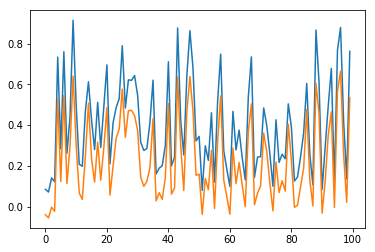

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
Y_pred=model.predict(X_train)
x_pred=np.arange(0,100,1)
plt.plot(x_pred,Y_train[:100])
plt.plot(x_pred,Y_pred[:100])

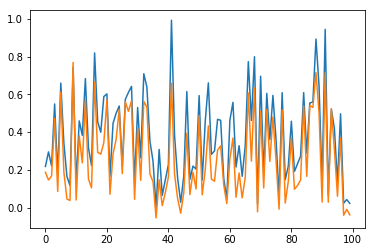

In [11]:
Y_pred=model.predict(X_test)
x_pred=np.arange(0,100,1)
plt.plot(x_pred,Y_test[:100])
plt.plot(x_pred,Y_pred[:100])

In [ ]:
print(np.mean(np.square(Y_test.reshape(-1)-Y_pred.reshape(-1))))
print(np.mean(np.abs(Y_test.reshape(-1)-Y_pred.reshape(-1))))

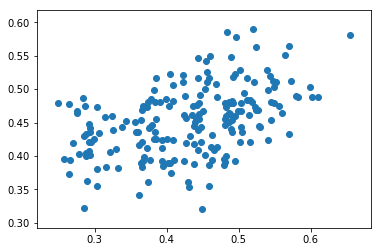

In [5]:
plt.scatter(Y_test.reshape(-1),Y_pred)